In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf
from tensorflow import keras

print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

sys.version_info(major=3, minor=7, micro=5, releaselevel='final', serial=0)
matplotlib 3.1.2
numpy 1.17.4
pandas 0.25.3
sklearn 0.22
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


## 1. 数据的读取与展示

In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train_all, y_train_all),(x_test, y_test) = fashion_mnist.load_data()
x_valid, x_train = x_train_all[ :5000], x_train_all[5000: ]
y_valid, y_train = y_train_all[ :5000], y_train_all[5000: ]

### 1.1 数据归一化

In [3]:
# x = (x - u) / std

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# x_train: [None, 28, 28]  -> [None, 784]
# 注意：在训练数据中的数据归一化用 fit_transform，在验证集和测试集中用的是 transform，这是因为要保证均值和方差一致
x_train_scaled = scaler.fit_transform(x_train.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
x_valid_scaled = scaler.transform(x_valid.astype(np.float32).reshape(-1,1)).reshape(-1, 28, 28)
x_test_scaled = scaler.transform(x_test.astype(np.float32).reshape(-1,1)).reshape(-1, 28, 28)

## 2. 模型构建

### 2.1 【重点】构建架构（dropout的使用）

In [4]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
for _ in range(15):
    model.add(keras.layers.Dense(100, activation="selu")) 
#AlphaDropout：1. 均值和方差不变； 2. 归一化性质不变
# model.add(keras.layers.Dropout(rate=0.5))， tensorflow将dropout实现为一个层
model.add(keras.layers.AlphaDropout(rate=0.5)) 
model.add(keras.layers.Dense(10, activation="softmax"))


model.compile(loss="sparse_categorical_crossentropy", optimizer ="sgd", metrics = ["accuracy"])               

### 2.2 查看模型架构

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               1

## 3. 训练模型

In [6]:
# TensorBoard,   EarlyStopping,   ModelCheckpoint
logdir = "./dnn-callbacks"
if not os.path.exists(logdir):
    os.mkdir(logdir)
output_model_file = os.path.join(logdir, "fashion_mnist_model.h5")

callbacks = [
    keras.callbacks.TensorBoard(logdir, profile_batch = 100000000),
    keras.callbacks.ModelCheckpoint(output_model_file, save_best_only = True),
    keras.callbacks.EarlyStopping(patience=5, min_delta=1e-3),
]
history = model.fit(x_train_scaled, y_train, epochs=10, 
                    validation_data=(x_valid_scaled, y_valid),
                    callbacks = callbacks)

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 8s 146us/sample - loss: 0.6661 - accuracy: 0.7751 - val_loss: 0.5600 - val_accuracy: 0.8464
Epoch 2/10
55000/55000 [==============================] - 7s 119us/sample - loss: 0.4452 - accuracy: 0.8466 - val_loss: 0.5301 - val_accuracy: 0.8630
Epoch 3/10
55000/55000 [==============================] - 6s 114us/sample - loss: 0.3955 - accuracy: 0.8618 - val_loss: 0.4934 - val_accuracy: 0.8676
Epoch 4/10
55000/55000 [==============================] - 6s 113us/sample - loss: 0.3642 - accuracy: 0.8723 - val_loss: 0.5013 - val_accuracy: 0.8758
Epoch 5/10
55000/55000 [==============================] - 6s 118us/sample - loss: 0.3441 - accuracy: 0.8778 - val_loss: 0.5140 - val_accuracy: 0.8806
Epoch 6/10
55000/55000 [==============================] - 6s 116us/sample - loss: 0.3281 - accuracy: 0.8837 - val_loss: 0.4861 - val_accuracy: 0.8866
Epoch 7/10
55000/55000 [===========================

## 4. 查看训练历史

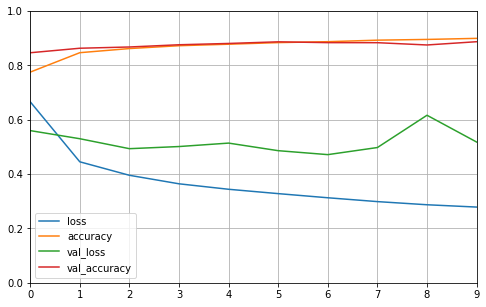

In [7]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True) 
    plt.gca().set_ylim(0, 1)
    plt.show()
plot_learning_curves(history)

## 5. 测试数据

In [8]:
model.evaluate(x_test_scaled, y_test)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.6183615644574165, 0.874]